In [102]:
# Import the package if needed
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import json
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the Logarithmic Loss function for evaluating the submissions
def logloss(y_true, y_pred, eps=1e-15):
    import numpy as np

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    assert (len(y_true) and len(y_true) == len(y_pred))

    p = np.clip(y_pred, eps, 1-eps)
    loss = np.sum(- y_true * np.log(p) - (1 - y_true) * np.log(1-p))

    return loss / len(y_true)

In [3]:
# Define the info function to check the overall info of train data
def info(data):
    output = []

    for col in data.columns:

        nonNull  = len(data) - np.sum(pd.isna(data[col]))
        unique = data[col].nunique()
        colType = str(data[col].dtype)

        output.append([col, nonNull, unique, colType])

    output = pd.DataFrame(output)   
    output.columns = ['colName','non-null', 'unique', 'dtype']
    
    return output

In [4]:
# Import the datasets
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

# Exporatory Data Analysis

In [5]:
# To understand the dataset, show the infomation of each column
info(df_train)
# Approximately 40 millions rows of data, with no null values

,colName,non-null,unique,dtype
0,id,40428967,40428967,float64
1,click,40428967,2,int64
2,hour,40428967,240,int64
3,C1,40428967,7,int64
4,banner_pos,40428967,7,int64
5,site_id,40428967,4737,object
6,site_domain,40428967,7745,object
7,site_category,40428967,26,object
8,app_id,40428967,8552,object
9,app_domain,40428967,559,object


In [6]:
df_train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


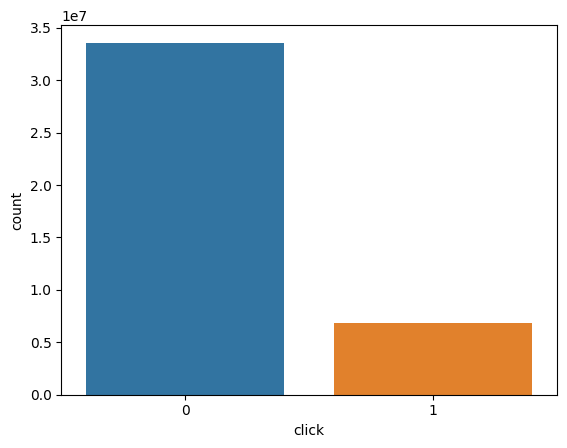

The probability that user will click the ads in average is:16.98%


In [7]:
# What is the probability user will click the ads in average?
sns.countplot(df_train['click'])
plt.show()
print("The probability that user will click the ads in average is:{:.2f}%".format((len(df_train[df_train['click'] == 1]) / len(df_train))*100))

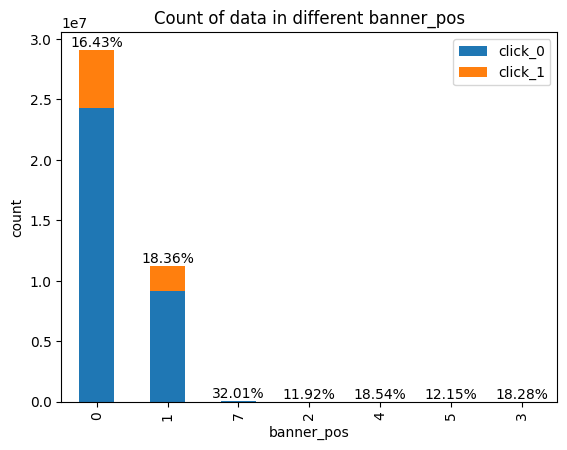

In [8]:
# How does variable 'banner_pos' affect on the ctr?

click_0 = df_train['banner_pos'][df_train['click'] == 0].value_counts()
click_1 = df_train['banner_pos'][df_train[ 'click'] == 1].value_counts()

df_tmp = pd.DataFrame({'click_0':click_0, 'click_1':click_1})

df_tmp['ctr'] = df_tmp['click_1'] / (df_tmp['click_0'] + df_tmp['click_1'])
df_tmp['ctr'] = df_tmp['ctr'].apply(lambda x: '{:.2f}%'.format(x*100))

df_tmp['total'] = df_tmp['click_0'] + df_tmp['click_1']
df_tmp = df_tmp.sort_values('total', ascending = False)

ax  = df_tmp[['click_0', 'click_1']].plot(kind = 'bar', stacked = True)

ax.set_xlabel("banner_pos")
ax.set_ylabel("count")

ax.bar_label(ax.containers[1], labels=df_tmp['ctr'], label_type='edge')

plt.title('Count of data in different banner_pos')
plt.show()

# 1. The more front position of ads, the higher the impressions and clicked times
# 2. 'banner_pos' = 7 has the highest ctr

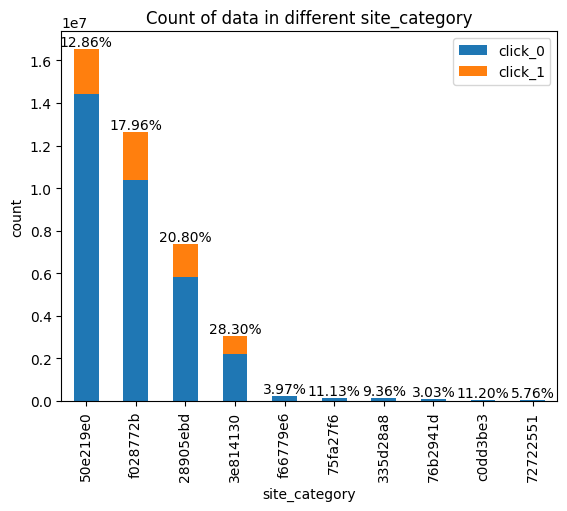

In [9]:
# What is the relationship between varible 'site_category' and ctr?
click_0 = df_train['site_category'][df_train['click'] == 0].value_counts()
click_1 = df_train['site_category'][df_train[ 'click'] == 1].value_counts()

df_tmp = pd.DataFrame({'click_0':click_0, 'click_1':click_1})

df_tmp['ctr'] = df_tmp['click_1'] / (df_tmp['click_0'] + df_tmp['click_1'])
df_tmp['ctr'] = df_tmp['ctr'].apply(lambda x: '{:.2f}%'.format(x*100))

df_tmp['total'] = df_tmp['click_0'] + df_tmp['click_1']
df_tmp = df_tmp.sort_values('total', ascending = False)[:10]

ax  = df_tmp[['click_0', 'click_1']].plot(kind = 'bar', stacked = True)

ax.set_xlabel("site_category")
ax.set_ylabel("count")

ax.bar_label(ax.containers[1], labels=df_tmp['ctr'], label_type='edge')

plt.title('Count of data in different site_category')
plt.show()

# 1. 'site_category' = '50e219e0' has highest impressions, yet the ctr is not as good as average
# 2. 'site_category' = '3e814130' has the highest ctr

#### -> We can understand that variety of input variables may affect the CTR

## Feature Engineering 

In [13]:
# To avoid the unrepresentative sample, StratifiedShuffleSplit is used
split = StratifiedShuffleSplit(n_splits=1, train_size=0.01, random_state=1)
sample_index = []
for train_index, val_index in split.split(df_train.loc[:, df_train.columns != 'click'], df_train["click"]):
    sample_index = train_index
    
df_train_sample = df_train.loc[sample_index]

In [15]:
# Check if the ctr is representive in sample train data
print("The CTR of sample data:{}".format((len(df_train_sample[df_train_sample['click'] == 1]) / len(df_train_sample))*100))
print("The CTR of original data:{}".format((len(df_train[df_train['click'] == 1]) / len(df_train))*100))

The CTR of sample data:16.980674715364504
The CTR of original data:16.980562476404604


In [16]:
# Set the test dataset as the same format as train 
# Combine two dataset for feature engineering in convenience
df_test.insert(0, 'click', 0)
df_testTrain = pd.concat([df_test, df_train_sample], copy=False)

In [17]:
print("df_test len:", len(df_test))
print("df_train_sample len:", len(df_train_sample))
print("df_testTrain:", len(df_testTrain))
df_testTrain.head()

df_test len: 4577464
df_train_sample len: 404289
df_testTrain: 4981753


,click,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100075,23
1,0,1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22676,320,50,2616,0,35,100083,51
2,0,1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,22676,320,50,2616,0,35,100083,51
3,0,1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,...,1,0,18648,320,50,1092,3,809,100156,61
4,0,1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,...,1,0,23160,320,50,2667,0,47,-1,221


In [18]:
# Drop Id since every row data has its unique value, this feature can not become an input variable
df_testTrain.drop(['id', 'C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19' ,'C20', 'C21'], inplace=True, axis=1)

In [19]:
info(df_testTrain)

,colName,non-null,unique,dtype
0,click,4981753,2,int64
1,hour,4981753,264,int64
2,banner_pos,4981753,7,int64
3,site_id,4981753,3137,object
4,site_domain,4981753,3700,object
5,site_category,4981753,23,object
6,app_id,4981753,4554,object
7,app_domain,4981753,249,object
8,app_category,4981753,29,object
9,device_id,4981753,351118,object


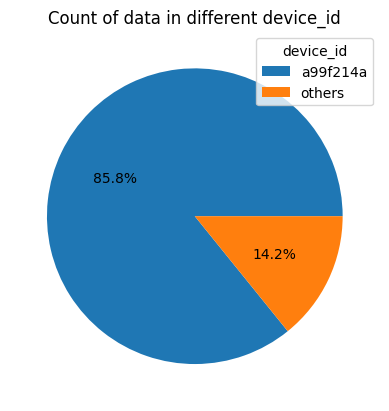

In [20]:
# 1. We can see that device_id = a99f214a are recorded 86% among all data
df_a99f214a = df_testTrain[df_testTrain['device_id'] == 'a99f214a']
df_others = df_testTrain[df_testTrain['device_id'] != 'a99f214a']
pie = plt.pie([len(df_a99f214a), len(df_others)], autopct= '%1.1f%%')
plt.legend(pie[0], title='device_id', labels = ['a99f214a', 'others'], bbox_transform=plt.gcf().transFigure)
plt.title('Count of data in different device_id')
plt.show()

In [21]:
# A new feature 'user' will be defined as this device_id, otherwise it would be device_ip + device_model, and these three features will be removed
df_testTrain['user'] = df_testTrain['device_id'].where(df_testTrain['device_id'] == 'a99f214a', df_testTrain['device_ip'] + df_testTrain['device_model'])
df_testTrain.drop(['device_id', 'device_ip', 'device_model'], inplace=True, axis=1)
df_testTrain['user'].value_counts()

a99f214a            4275291
8f500d36ad328c4d        559
ba10a8400f33af29        506
44d2ddc65db079b5        412
9e93a20bd787e91b        397
                     ...   
870b63775096d134          1
e41f3d5980b1a1d2          1
65ad1e814ea23a13          1
f31027aa84ebbcd4          1
e0dfd44943e7b962          1
Name: user, Length: 361746, dtype: int64

In [22]:
# 2. For categorical variables, to avoid decrease other features importance, only top 50 fequency feature will be one-hot encoded, others will be setted as 'others'
def saveTopFiftyFrequentDict(feature):

    feature_count = df_testTrain[feature].value_counts()
    feature_top_fifty={}
    feature_top_fifty[1] = feature_count[:50].index.values
    feature_top_fifty[0] = feature_count[50:].index.values

    feature_top_fifty_dict = {}
    for key, values in feature_top_fifty.items():
        for item in values:
            feature_top_fifty_dict[str(item)] = key

    json.dump(feature_top_fifty_dict, open("Output/{}_top_fifty_dict.json".format(feature), "w"))

In [23]:
saveTopFiftyFrequentDict('site_id')
saveTopFiftyFrequentDict('site_domain')
saveTopFiftyFrequentDict('app_id')
saveTopFiftyFrequentDict('app_domain')
saveTopFiftyFrequentDict('user')

In [24]:
site_id_top_fifty_dict = json.load(open("Output/site_id_top_fifty_dict.json", "r"))
site_domain_top_fifty_dict = json.load(open("Output/site_domain_top_fifty_dict.json", "r"))
app_id_top_fifty_dict = json.load(open("Output/app_id_top_fifty_dict.json", "r"))
app_domain_top_fifty_dict = json.load(open("Output/app_domain_top_fifty_dict.json", "r"))
user_top_fifty_dict = json.load(open("Output/user_top_fifty_dict.json", "r"))

df_testTrain['site_id'] = df_testTrain['site_id'].apply(lambda x: x if site_id_top_fifty_dict.get(x)==1 else "other_site_id")
df_testTrain['site_domain'] = df_testTrain['site_domain'].apply(lambda x: x if site_domain_top_fifty_dict.get(x)==1 else "other_site_domain")
df_testTrain['app_id'] = df_testTrain["app_id"].apply(lambda x: x if app_id_top_fifty_dict.get(x)==1 else "other_app_id")
df_testTrain['app_domain'] = df_testTrain['app_domain'].apply(lambda x: x if app_domain_top_fifty_dict.get(x)==1 else "other_device_model")
df_testTrain['user'] = df_testTrain['user'].apply(lambda x: x if user_top_fifty_dict.get(x)==1 else "other_user")

In [25]:
info(df_testTrain)

,colName,non-null,unique,dtype
0,click,4981753,2,int64
1,hour,4981753,264,int64
2,banner_pos,4981753,7,int64
3,site_id,4981753,51,object
4,site_domain,4981753,51,object
5,site_category,4981753,23,object
6,app_id,4981753,51,object
7,app_domain,4981753,51,object
8,app_category,4981753,29,object
9,device_type,4981753,5,int64


In [26]:
# 3. For the time variable, we consider ctr might be related to day or hour
df_testTrain = df_testTrain.rename(columns={'hour': 'date_tmp'})
df_testTrain['day'] = np.round(df_testTrain['date_tmp'] % 10000 / 100)
df_testTrain['hour'] = np.round(df_testTrain['date_tmp'] % 100)
df_testTrain.drop('date_tmp', inplace=True, axis=True)

In [27]:
df_testTrain

,click,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_type,device_conn_type,user,day,hour
0,0,0,other_site_id,other_site_domain,f028772b,ecad2386,7801e8d9,07d7df22,1,0,a99f214a,31.0,0
1,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,1,0,a99f214a,31.0,0
2,0,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,1,0,a99f214a,31.0,0
3,0,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,1,0,a99f214a,31.0,0
4,0,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,1,0,a99f214a,31.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16688545,0,1,other_site_id,other_site_domain,3e814130,ecad2386,7801e8d9,07d7df22,1,0,a99f214a,25.0,0
36906637,0,0,85f751fd,c4e18dd6,50e219e0,other_app_id,2347f47a,0f2161f8,1,0,a99f214a,30.0,4
25784930,0,0,other_site_id,other_site_domain,50e219e0,ecad2386,7801e8d9,07d7df22,0,0,other_user,27.0,14
1740445,0,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,1,0,a99f214a,21.0,8


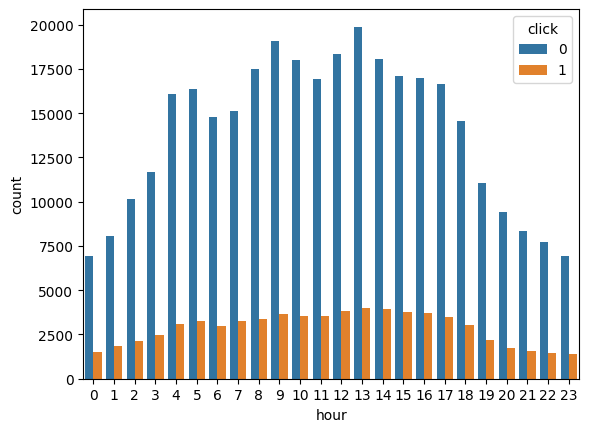

In [28]:
# We found that impressions are more frequent during daytime
sns.countplot(x="hour", hue="click",data=df_testTrain[len(df_test):])
plt.show()

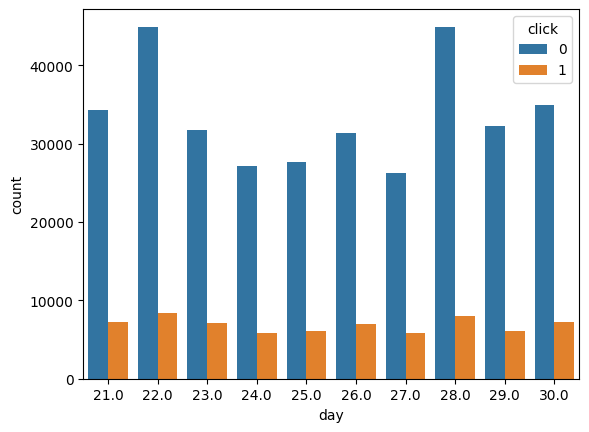

In [29]:
sns.countplot(x="day", hue="click",data=df_testTrain[len(df_test):])
plt.show()

In [30]:
info(df_testTrain)

,colName,non-null,unique,dtype
0,click,4981753,2,int64
1,banner_pos,4981753,7,int64
2,site_id,4981753,51,object
3,site_domain,4981753,51,object
4,site_category,4981753,23,object
5,app_id,4981753,51,object
6,app_domain,4981753,51,object
7,app_category,4981753,29,object
8,device_type,4981753,5,int64
9,device_conn_type,4981753,4,int64


In [31]:
# Encode the categorical variable and create dummies features
encoder = preprocessing.LabelEncoder() 
features = ['banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_type', 'device_conn_type', 'user', 'day', 'hour']
df_testTrain_new = df_testTrain
for feature in features:
    df_testTrain[feature] = encoder.fit_transform(df_testTrain[feature])
    dummies_feature_category = pd.get_dummies(df_testTrain[feature], prefix = feature)
    df_testTrain_new = pd.concat([df_testTrain_new, dummies_feature_category], axis=1)

In [32]:
df_testTrain_new.drop(features, inplace=True, axis=1)
df_testTrain_new

,click,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_6,site_id_0,site_id_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16688545,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36906637,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25784930,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1740445,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Export both data to csv
df_train_new = df_testTrain_new.iloc[len(df_test):,]
df_train_new.to_csv('Data/df_train_new.csv')

In [34]:
df_test_new = df_testTrain_new.iloc[:len(df_test),]
df_test_new.to_csv('Data/df_test_new.csv')

In [38]:
df_train_new.head()

,click,banner_pos_0,banner_pos_1,banner_pos_2,banner_pos_3,banner_pos_4,banner_pos_5,banner_pos_6,site_id_0,site_id_1,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
6442340,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14358030,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2448506,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23823328,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
29536614,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Make new Submission
newSubmission = pd.read_csv('Data/sampleSubmission.csv')
newSubmission.drop(columns = 'click', inplace = True)
newSubmission['click'] = predictions
newSubmission = newSubmission.reset_index(drop=True)
sampleSubmission.to_csv('Data/newSubmission.csv', index=False)